In [1]:
%matplotlib inline

import numpy as np
import scipy.optimize as opt

from astroML.datasets import fetch_hogg2010test
from astropy.table import Table
from statsmodels.api import qqplot

from numba import njit               #speed functions up with numba
import matplotlib.pyplot as plt

# Problem 1

In [2]:
@njit
def normal_loss(y, dy, y_model):
    return (y - y_model)**2/dy**2/2

@njit
def log_likelihood(loss):
    return -np.sum(loss)

@njit
def get_logp_grid(x, y, dy, avals, bvals, loss_func):

    logp = np.zeros((len(avals), len(bvals)))

    for i in range(len(avals)):
        for j in range(len(bvals)):

            line_y = avals[i]*x + bvals[j]
            logp[i, j] = log_likelihood(loss_func(y, dy, line_y))

    return logp



@njit
def get_leastsqr_line(x, y, dy, da, db, loss_func):

    #Get mean slope as an estimate for a
    slopes = np.zeros(len(x)-1)
    for i in range(1, len(x)):
        slopes[i-1] = (y[i] - y[i-1])/(x[i] - x[i-1])

    mean_slope = np.mean(slopes)

    #Get ln(L) grid
    avals = np.arange( max(mean_slope-10, 0), mean_slope+10, da)
    bvals = np.arange(0, 400, db)

    logp = get_logp_grid(x, y, dy, avals, bvals, loss_func)


    #Find min of -ln(L)
    min_ind = np.argmin(-logp)

    return avals, bvals, logp, min_ind


In [3]:
data = fetch_hogg2010test()
x_dat = data['x']
y_dat = data['y']
dy_dat = data['sigma_y']

## No $\sigma$-clipping

In [4]:
da = .1
db = 1
avals, bvals, logp, min_ind = get_leastsqr_line(x_dat, y_dat, dy_dat, da, db, normal_loss)

min_ind = np.unravel_index( min_ind, logp.shape )
amin = avals[min_ind[0]]
bmin = bvals[min_ind[1]]

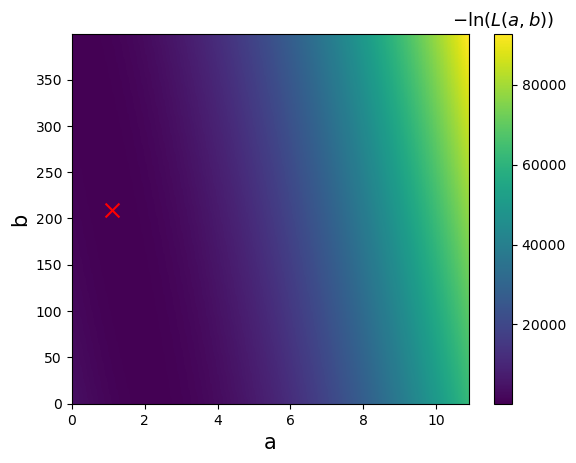

a =  1.1
b =  209


In [5]:
im = plt.imshow( -logp.T, aspect='auto', origin='lower', extent=[avals[0], avals[-1], bvals[0], bvals[-1]] )
plt.scatter( [amin], [bmin], marker='x', color='r', s=100 )

cbar = plt.colorbar(im)
cbar.ax.set_title( r'$-\ln( L(a,b) )$', fontsize=13 )

plt.ylabel('b', fontsize=15)
plt.xlabel('a', fontsize=15)

plt.show()

print('a = ', amin)
print('b = ', bmin)

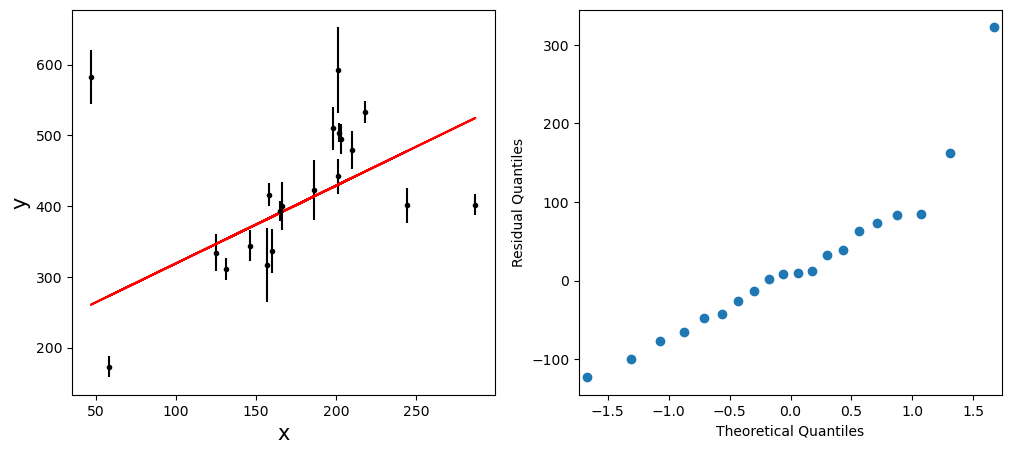

In [6]:
fig, ax = plt.subplots(1, 2, figsize=(12, 5))


yline = amin*x_dat + bmin

ax[0].errorbar(x_dat, y_dat, dy_dat, fmt='.k')
ax[0].plot(x_dat, yline, '-r')
ax[0].set_xlabel('x', fontsize=15)
ax[0].set_ylabel('y', fontsize=15)


qqplot(y_dat - yline, ax=ax[1]);
ax[1].set_ylabel('Residual Quantiles')
plt.show()

## With $\sigma$-clipping

In [7]:
def sigma_clip(y, dy, nsig=3):
    return np.abs(y - np.mean(y)) > nsig*dy

clip_mask = sigma_clip(y_dat-yline, dy_dat, nsig=3)

x_clip = x_dat[~clip_mask]
y_clip = y_dat[~clip_mask]
dy_clip = dy_dat[~clip_mask]

In [8]:
da = .1
db = 1
avals, bvals, logp, min_ind = get_leastsqr_line(x_clip, y_clip, dy_clip, da, db, normal_loss)

min_ind = np.unravel_index( min_ind, logp.shape )
amin = avals[min_ind[0]]
bmin = bvals[min_ind[1]]

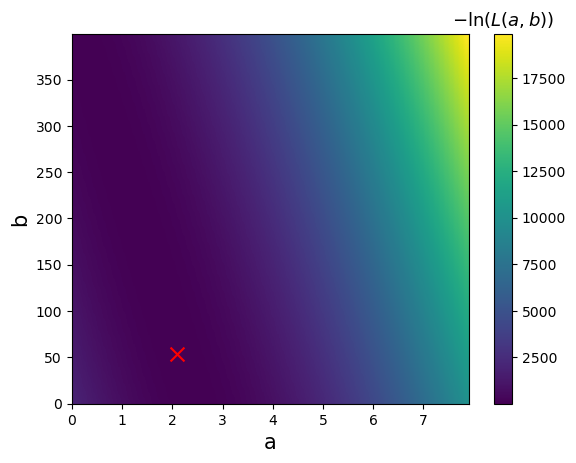

a =  2.1
b =  54


In [9]:
im = plt.imshow( -logp.T, aspect='auto', origin='lower', extent=[avals[0], avals[-1], bvals[0], bvals[-1]] )
plt.scatter( [amin], [bmin], marker='x', color='r', s=100 )

cbar = plt.colorbar(im)
cbar.ax.set_title( r'$-\ln(L(a,b))$', fontsize=13 )

plt.ylabel('b', fontsize=15)
plt.xlabel('a', fontsize=15)

plt.show()

print('a = ', amin)
print('b = ', bmin)

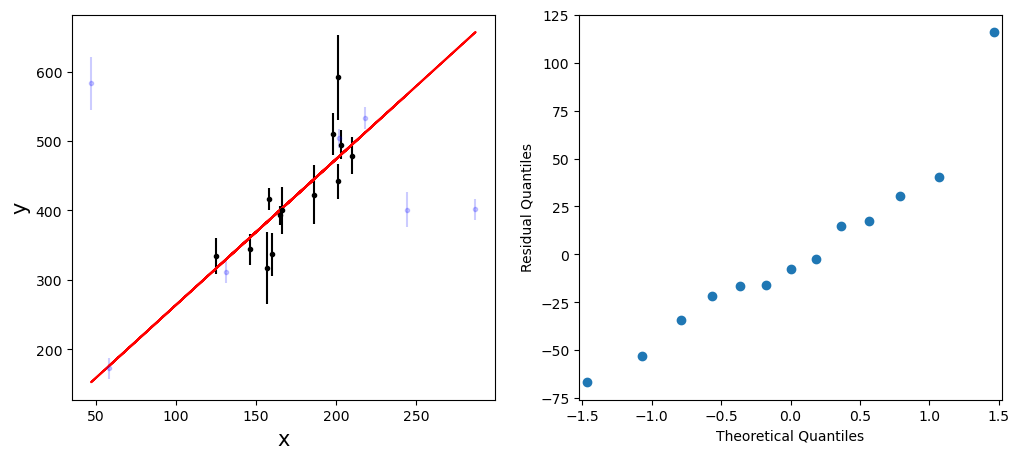

In [10]:
yline = amin*x_dat + bmin
yline_clip = amin*x_clip + bmin


fig, ax = plt.subplots(1, 2, figsize=(12, 5))

ax[0].errorbar(x_clip, y_clip, dy_clip, fmt='.k')
ax[0].errorbar(x_dat[clip_mask], y_dat[clip_mask], dy_dat[clip_mask], fmt='.', color='blue', alpha=.2)
ax[0].plot(x_dat, yline, '-r')

ax[0].set_xlabel('x', fontsize=15)
ax[0].set_ylabel('y', fontsize=15)

qqplot(y_clip - yline_clip, ax=ax[1]);
ax[1].set_ylabel('Residual Quantiles')
plt.show()

## Huber method

In [11]:
@njit
def huber_loss(y, dy, y_model, delta):

    mask = np.abs( y - y_model ) <= delta
    loss = np.zeros(len(y), dtype=float)

    loss[mask] = ( y[mask] - y_model[mask] )**2 / dy[mask]**2 /2
    loss[~mask] = delta*np.abs( (y[~mask] - y_model[~mask])/dy[~mask]**2 ) - .5*delta/dy[~mask]**2
    
    return loss


def huber_nll(params, x, y, dy):
    a, b = params

    y_model = a*x + b
    loss = huber_loss(y, dy, y_model, .5)
    return -log_likelihood(loss)

In [12]:
a_huber, b_huber = opt.fmin(huber_nll, x0=[1, 1], args=(x_dat, y_dat, dy_dat), disp=False)

print('a = ', a_huber)
print('b = ', b_huber)

a =  2.056073774603366
b =  54.247830508652356


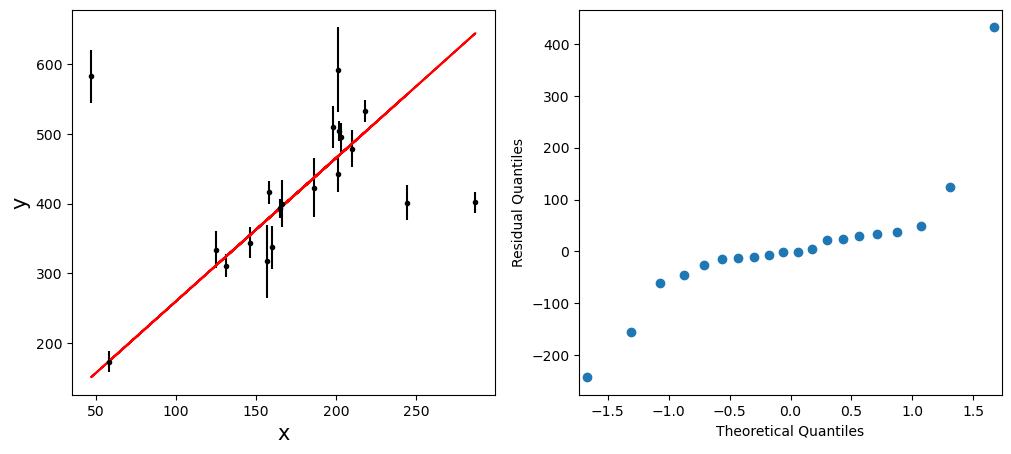

In [13]:
yline = a_huber*x_dat + b_huber


fig, ax = plt.subplots(1, 2, figsize=(12, 5))

ax[0].errorbar(x_dat, y_dat, dy_dat, fmt='.k')
ax[0].plot(x_dat, yline, '-r')
ax[0].set_xlabel('x', fontsize=15)
ax[0].set_ylabel('y', fontsize=15)

qqplot( y_dat - yline, ax=ax[1]);
ax[1].set_ylabel('Residual Quantiles')
plt.show()

# Problem 2

In [14]:
ceph_dat = Table.read('Cepheids.csv', format='ascii.csv')

In [15]:
lmc_mask = (ceph_dat['Cloud'] == 'LMC')
mode_f_mask = (ceph_dat['Mode'] == 'F')

lmc_f = ceph_dat[ lmc_mask & mode_f_mask ]
lmc_1 = ceph_dat[ lmc_mask & ~mode_f_mask ]

smc_f = ceph_dat[ ~lmc_mask & mode_f_mask ]
smc_1 = ceph_dat[ ~lmc_mask & ~mode_f_mask ]

In [17]:
dat_arrays = [lmc_f, lmc_1, smc_f, smc_1]
names = ['LMC F', 'LMC 1', 'SMC F', 'SMC 1']


amin = np.zeros(4)
bmin = np.zeros(4)
for i, dat in enumerate(dat_arrays):
    y_ceph = dat['W']
    x_ceph = dat['logP1']
    dy_ceph = np.full(len(x_ceph), np.std(y_ceph))

    #First-pass fit
    a_huber, b_huber = opt.fmin(huber_nll, x0=[-1, 1], args=(x_ceph, y_ceph, dy_ceph), disp=False)
    amin[i] = a_huber
    bmin[i] = b_huber


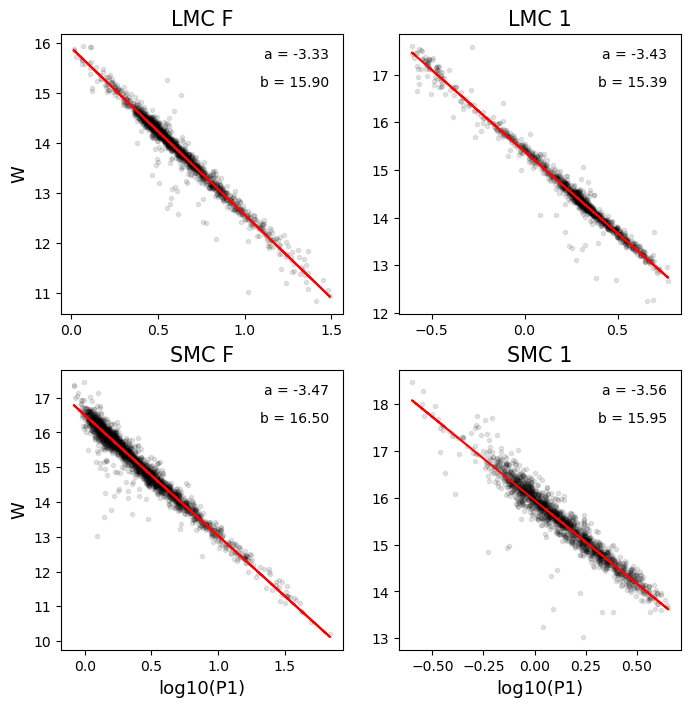

In [18]:
fig, ax = plt.subplots(2,2, figsize=(8, 8))

for i, (name, dat) in enumerate(zip(names, dat_arrays)):
    ax_ind = (i//2, i%2)

    ax[ax_ind].errorbar(dat['logP1'], dat['W'], fmt='.k', alpha=.1, zorder=0)
    ax[ax_ind].plot(dat['logP1'], amin[i]*dat['logP1'] + bmin[i], c='r', zorder=100)
    ax[ax_ind].set_title(name, fontsize=15)

    ax[ax_ind].text(.95, .95, 'a = {:.2f}'.format(amin[i]), transform=ax[ax_ind].transAxes, ha='right', va='top', fontsize=10)
    ax[ax_ind].text(.95, .85, 'b = {:.2f}'.format(bmin[i]), transform=ax[ax_ind].transAxes, ha='right', va='top', fontsize=10)


    if ax_ind[1] == 0:
        ax[ax_ind].set_ylabel('W', fontsize=13)

    if ax_ind[0] == len(dat_arrays)//2 - 1:
        ax[ax_ind].set_xlabel('log10(P1)', fontsize=13)

plt.show()

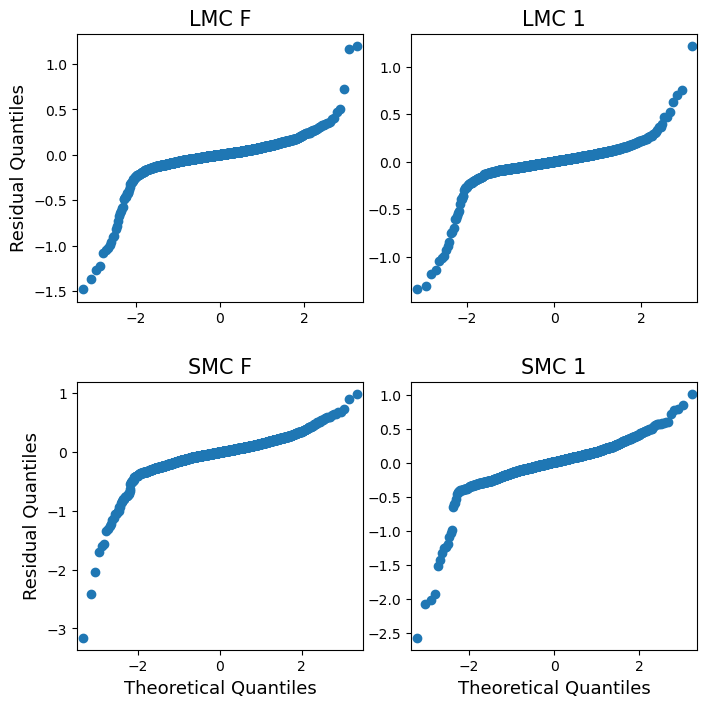

In [19]:
fig, ax = plt.subplots(2,2, figsize=(8, 8))

for i, (name, dat) in enumerate(zip(names, dat_arrays)):
    ax_ind = (i//2, i%2)

    line = amin[i]*dat['logP1'] + bmin[i]
    qqplot(dat['W'] - line, ax=ax[m,n]);
    ax[ax_ind].set_title(name, fontsize=15)

    if n == 0:
        ax[ax_ind].set_ylabel('Residual Quantiles', fontsize=13)
    else:
        ax[ax_ind].set_ylabel('')

    if m == len(dat_arrays)//2 - 1:
        ax[ax_ind].set_xlabel('Theoretical Quantiles', fontsize=13)
    else:
        ax[ax_ind].set_xlabel('')


plt.subplots_adjust(hspace=.3, wspace=.17)
plt.show()

The distributions of the residuals for all 4 samples do not seem Gaussian based on their QQ-plots. For all samples, the residuals deviate far from a Gaussian at the tails of the distribution, and do not show a straight line at the center. However, the residuals for the SMC samples seem to be more Gaussian than those for the LMC, as the SMC samples only deviate at the lower tail of the distribution.

In particular, there is more area under the Gaussian curve for the lower quantiles than the distribution for the residuals. Therefore, there is more likely to be negative residuals than positive residuals, comparing to a Gaussian(0,1) distribution.

This could mean there are many lower magnitude outliers in the sample, not following the linear relationship between ``W`` and the ``log10(P1)``. This can be seen in the previous plots showing the line fits. All samples show a number of outliers below the the parts of the sample well-fit by the line. These outliers could be from the lack of purity of the sample (maybe from extragalactic sources).

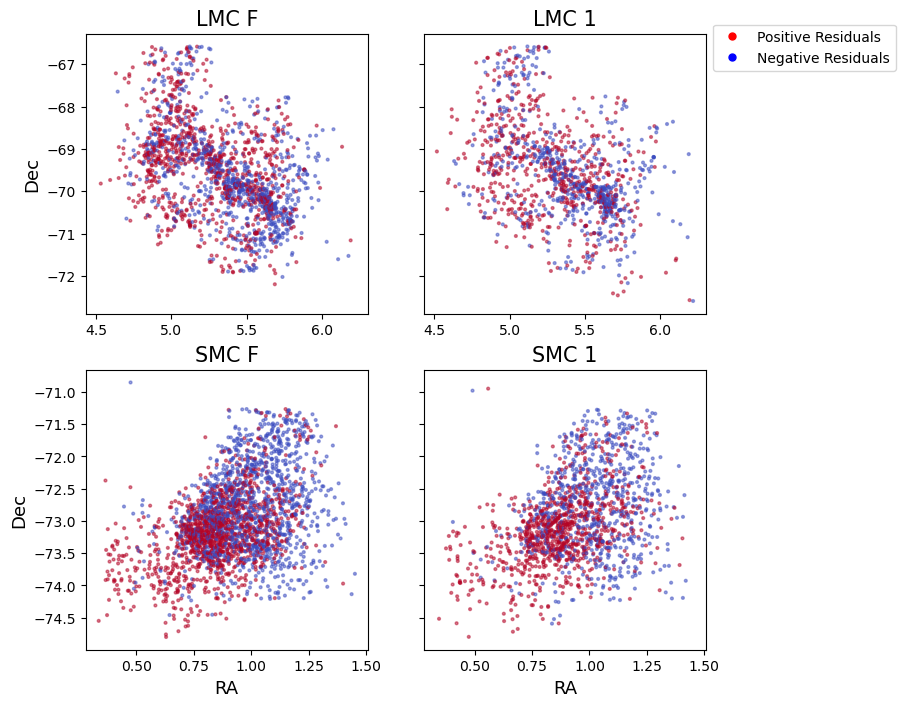

In [20]:
fig, ax = plt.subplots(2,2, figsize=(8, 8), sharey='row', sharex='row')

for i, (name, dat) in enumerate(zip(names, dat_arrays)):
    ax_ind = (i//2, i%2)

    line = amin[i]*dat['logP1'] + bmin[i]

    ax[ax_ind].scatter(dat['RA0'], dat['Decl0'], c=np.sign(dat['W'] - line), s=4, cmap='coolwarm', alpha=.5)
    ax[ax_ind].set_title(name, fontsize=15)

    if ax_ind[1] == 0:
        ax[ax_ind].set_ylabel('Dec', fontsize=13)

    if ax_ind[0] == len(dat_arrays)//2 - 1:
        ax[ax_ind].set_xlabel('RA', fontsize=13)


import matplotlib.lines as mlines
red_pt = mlines.Line2D([], [], color='red', marker='.', linestyle='None',
                          markersize=10, label='Positive Residuals')

blue_pt = mlines.Line2D([], [], color='blue', marker='.', linestyle='None',
                            markersize=10, label='Negative Residuals')

plt.figlegend(bbox_to_anchor=(.9, .9), loc='upper left', handles=[red_pt, blue_pt])
plt.show()

For all samples, there looks to be an even split of positive and negative residuals, with no strong clustering in RA/DEC. However, there are a few details in each sample that deviate from a uniform distrubution:

* SMC-F shows positive residuals and negative residuals clustering in the center. Positive residuals fall off towards the bottom left, and negative residuals fall off towards the top right.
* A similar phenomenon occurs in SMC-1, but the clustering at the center is confined to a smaller area.
* Both LMC samples show clustering in a bar towards the center, with positive and negative residuals scattered throughout.

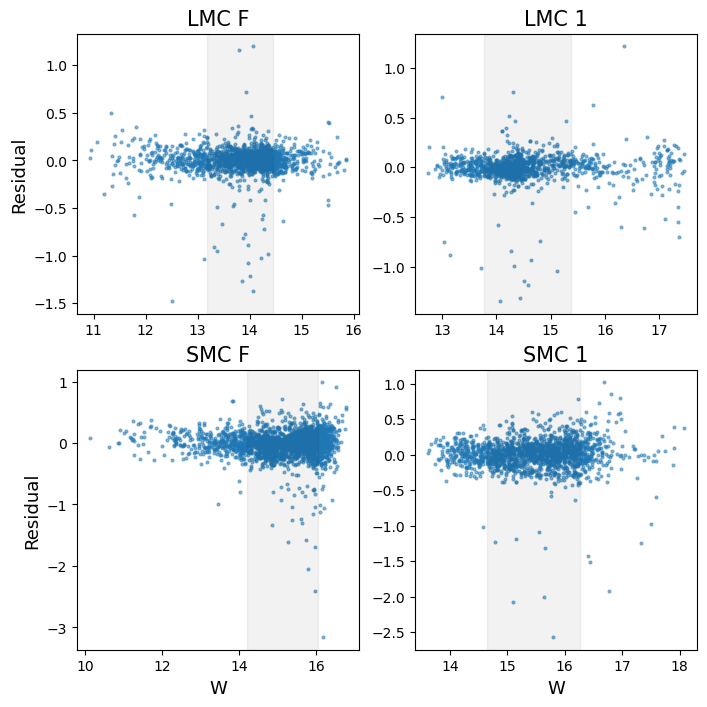

In [37]:
fig, ax = plt.subplots(2,2, figsize=(8, 8))

for i, (name, dat) in enumerate(zip(names, dat_arrays)):
    ax_ind = (i//2, i%2)

    line = amin[i]*dat['logP1'] + bmin[i]

    ax[ax_ind].scatter( line, dat['W']-line, s=4, alpha=.5)
    ax[ax_ind].axvspan( np.percentile(dat['W'], 16), np.percentile(dat['W'], 84), color='k', alpha=.05 )
    ax[ax_ind].set_title(name, fontsize=15)


    if ax_ind[1] == 0:
        ax[ax_ind].set_ylabel('Residual', fontsize=13)

    if ax_ind[0] == len(dat_arrays)//2 - 1:
        ax[ax_ind].set_xlabel('W', fontsize=13)

plt.show()

The residuals are centered around 0, with no particular clustering or trend with respect to the Wesenheit index ``W``. The apparent clustering in ``W`` is due to the fact that most of the sample lies within the clustered region of ``W``. To see this, I colored the $\pm 1\sigma$ region of the sample's ``W`` values a light gray.

There is an upturn in the residuals at large ``W`` for the fundamental mode stars in the SMC. The residuals for the SMC samples have a much larger spread than those for the LMC samples. 

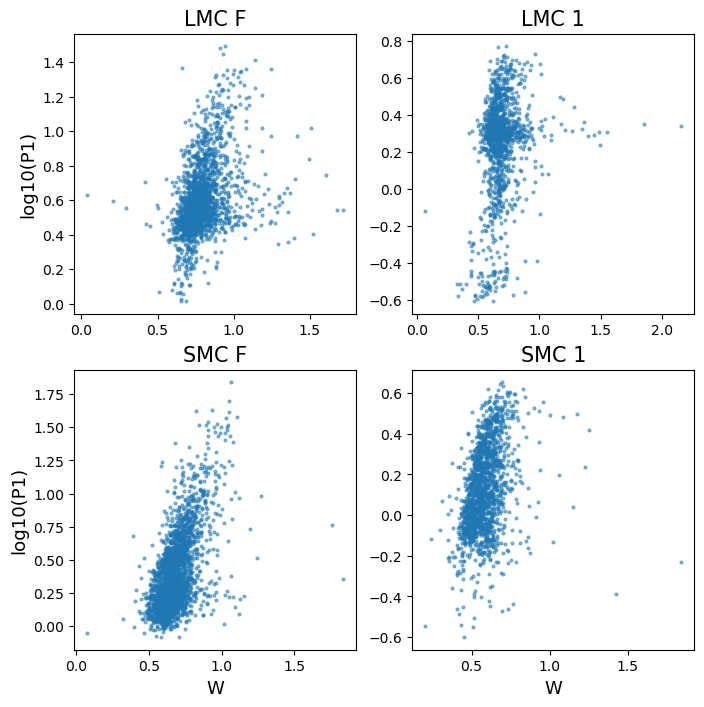

In [42]:
fig, ax = plt.subplots(2,2, figsize=(8, 8))
 
for i, (name, dat) in enumerate(zip(names, dat_arrays)):
    ax_ind = (i//2, i%2)


    ax[ax_ind].scatter( dat['VI'], dat['logP1'], s=4, alpha=.5)
    ax[ax_ind].set_title(name, fontsize=15)

    if ax_ind[1] == 0:
        ax[ax_ind].set_ylabel('log10(P1)', fontsize=13)

    if ax_ind[0] == len(dat_arrays)//2 - 1:
        ax[ax_ind].set_xlabel('W', fontsize=13)

plt.show()

There seems to be a positive relationship between the period and the V-I color of the Cepheid, regardless of the location (SMC or LMC). The least spread in the relationship is seen in the SMC with the fundamental mode stars. The most spread, and weakest relationship, is seen in the LMC with the first overtone stars.

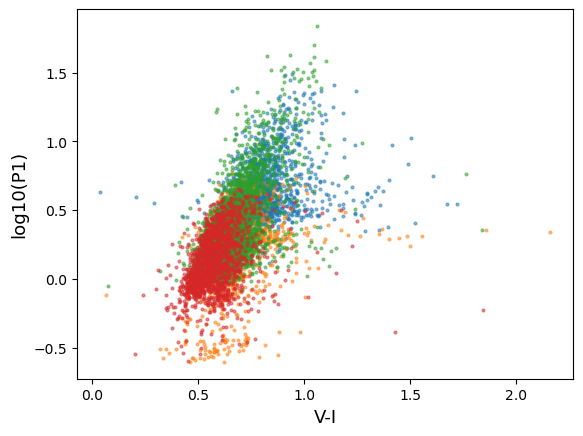

In [43]:
fig, ax = plt.subplots()
 
for i, (name, dat) in enumerate(zip(names, dat_arrays)):
    ax.scatter( dat['VI'], dat['logP1'], s=4, alpha=.5, label=name)

    ax.set_xlabel('V-I', fontsize=13)
    ax.set_ylabel('log10(P1)', fontsize=13)

plt.show()

Looking at all samples combined, all samples seem to follow the same relationship. This might be related to the period-luminosity relationship seen in Cepheids.